In [168]:
!pip install -U statsmodels

In [169]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [170]:
!wget https://lazyprogrammer.me/course_files/timeseries/temperature.csv

--2025-11-01 19:09:51--  https://lazyprogrammer.me/course_files/timeseries/temperature.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075992 (3.9M) [text/csv]
Saving to: ‘temperature.csv.5’

temperature.csv.5   100%[===================>]   3.89M  --.-KB/s    in 0.03s   

2025-11-01 19:09:52 (140 MB/s) - ‘temperature.csv.5’ saved [4075992/4075992]



In [171]:
df = pd.read_csv('temperature.csv')

In [172]:
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [173]:
def parse_date(row):
  s = f"{row['year']}-{row['month']}-{row['day']}"
  return datetime.strptime(s, "%Y-%m-%d")

In [174]:
df['Date'] = df.apply(parse_date, axis=1)

In [175]:
auckland = df[df['City'] == 'Auckland'].copy().dropna()
stockholm = df[df['City'] == 'Stockholm'].copy().dropna()

In [176]:
# keep only columns we want
auckland = auckland[['Date', 'AverageTemperatureFahr']].copy()
stockholm = stockholm[['Date', 'AverageTemperatureFahr']].copy()

In [177]:
# set index to date col
auckland.set_index(auckland['Date'], inplace=True)
auckland.drop('Date', axis=1, inplace=True)
auckland.columns = ['AucklandTemp']


In [178]:
auckland.head()

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


In [179]:
stockholm.set_index(stockholm['Date'], inplace=True)
stockholm.drop('Date', axis=1, inplace=True)
stockholm.columns = ['StockholmTemp']

In [180]:
stockholm.head()

,StockholmTemp
Date,
1743-11-01,42.8414
1744-04-01,36.8888
1744-05-01,45.1220
1744-06-01,53.1824
1744-07-01,60.0260


In [181]:
joined = auckland.join(stockholm, how='outer') # has some missing data

In [182]:
joined.shape

(3155, 2)

In [183]:
joined_part = joined.iloc[-500:].copy()
joined_part.index.freq = 'MS'

In [184]:
joined_part.isna().sum()

,0
AucklandTemp,1
StockholmTemp,4


In [185]:
joined_part.interpolate(inplace=True)

In [186]:
joined_part.isna().sum() # now all 0

,0
AucklandTemp,0
StockholmTemp,0


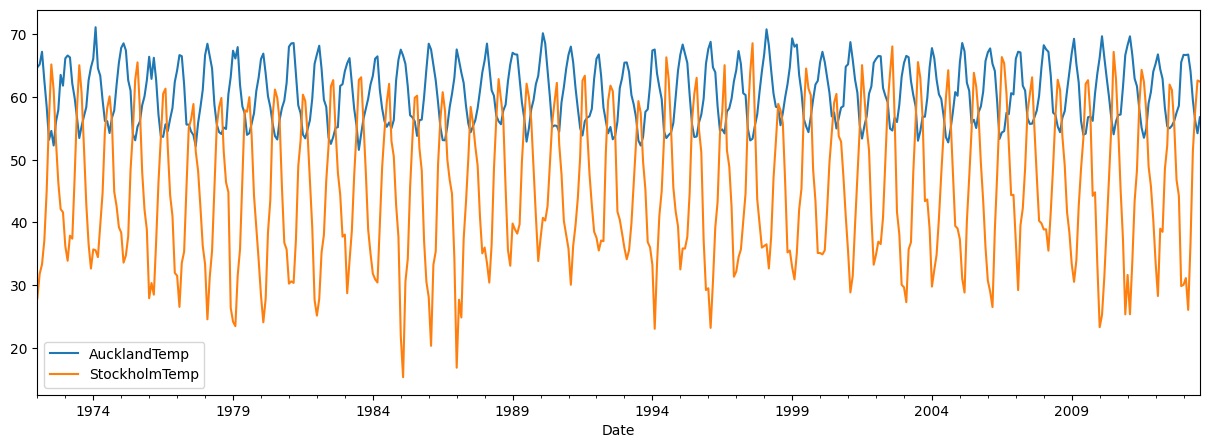

In [187]:
joined_part.plot(figsize=(15, 5));

In [188]:
Ntest = 12
train = joined_part.iloc[:-Ntest].copy()
test = joined_part.iloc[-Ntest:].copy()

In [189]:
scaler_auckland = StandardScaler()
train['ScaledAuckland'] = scaler_auckland.fit_transform(
    train[['AucklandTemp']])
test['ScaledAuckland'] = scaler_auckland.transform(test[['AucklandTemp']])

In [190]:
scaler_stockholm = StandardScaler()
train['ScaledStockholm'] = scaler_stockholm.fit_transform(
    train[['StockholmTemp']])
test['ScaledStockholm'] = scaler_stockholm.transform(test[['StockholmTemp']])

In [191]:
train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

In [192]:
# put them back in original df
joined_part.loc[train_idx, 'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[test_idx, 'ScaledAuckland'] = test['ScaledAuckland']
joined_part.loc[train_idx, 'ScaledStockholm'] = train['ScaledStockholm']
joined_part.loc[test_idx, 'ScaledStockholm'] = test['ScaledStockholm']

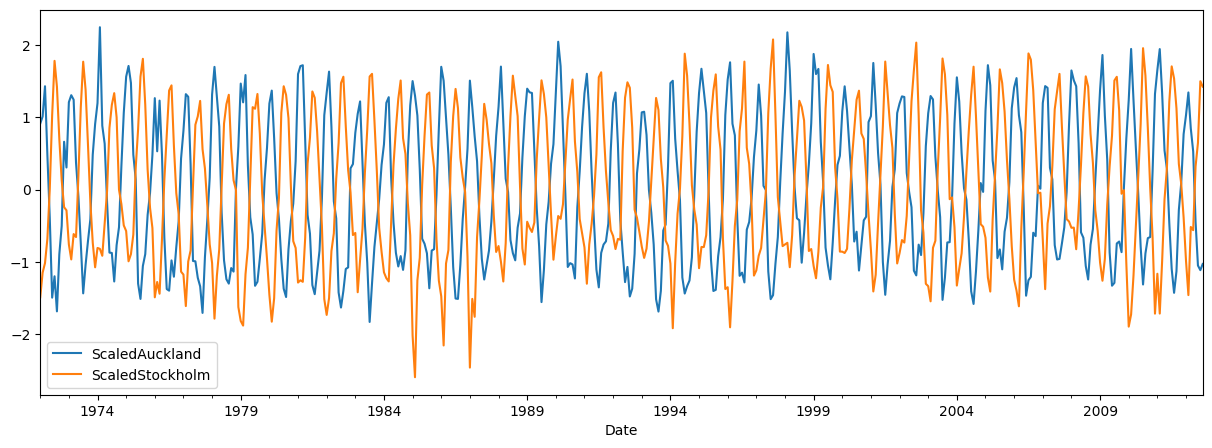

In [193]:
cols = ['ScaledAuckland', 'ScaledStockholm']
train[cols].plot(figsize=(15, 5));

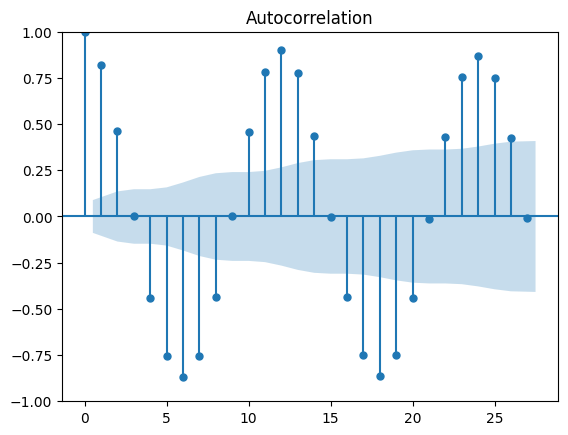

In [194]:
plot_acf(train['ScaledAuckland']);

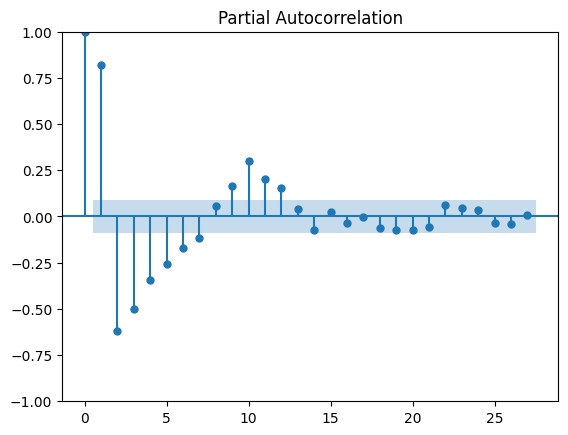

In [195]:
plot_pacf(train['ScaledAuckland']);

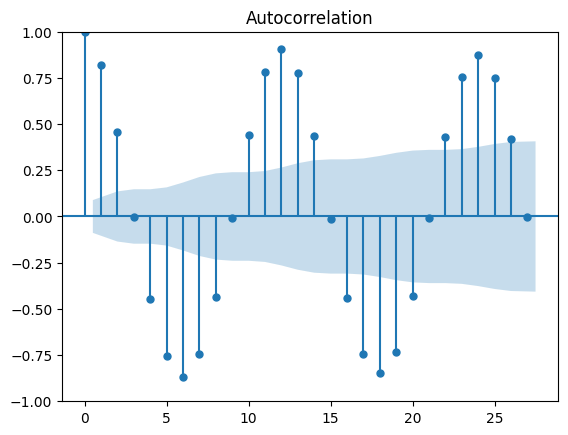

In [196]:
plot_acf(train['ScaledStockholm']);

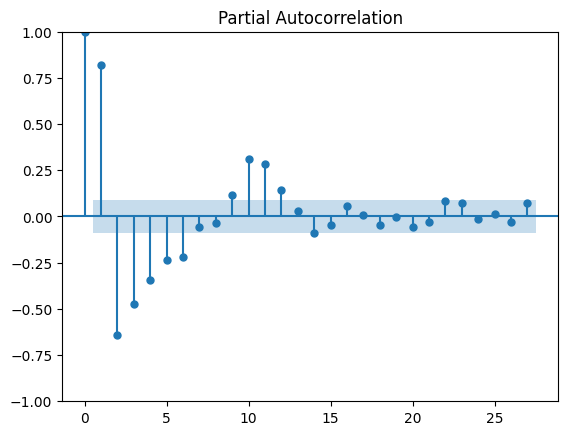

In [197]:
plot_pacf(train['ScaledStockholm']);

In [198]:
t0 = datetime.now()
model = VARMAX(train[cols], order=(10, 10))
res = model.fit(maxiter=100)
print("Duration:", datetime.now() - t0)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:04:13.249232


In [199]:
fcast = res.get_forecast(Ntest)

In [200]:
fcast.predicted_mean['ScaledAuckland']

,ScaledAuckland
2012-09-01,-0.900264
2012-10-01,-0.551451
2012-11-01,0.126217
2012-12-01,0.774897
2013-01-01,1.393283
2013-02-01,1.413130
2013-03-01,1.181138
2013-04-01,0.384915
2013-05-01,-0.285096
2013-06-01,-0.873937


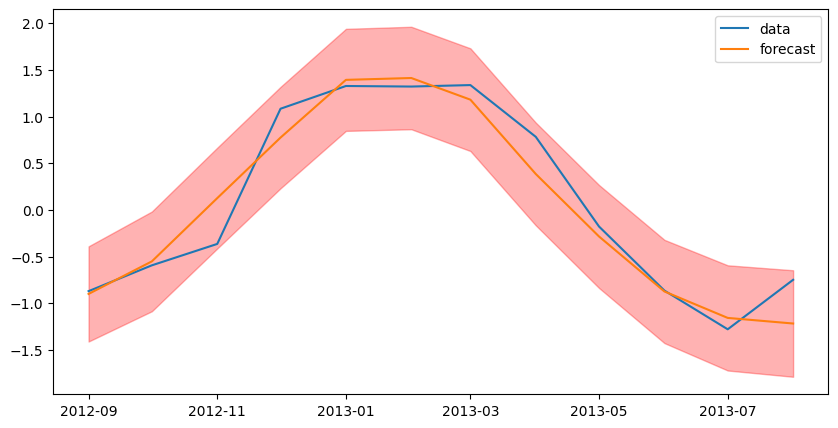

In [201]:
# exercise: also plot confidence intervals
test_pred = fcast.predicted_mean['ScaledAuckland']
confint = fcast.conf_int()[['lower ScaledAuckland','upper ScaledAuckland']]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(joined_part.index[-Ntest:], test['ScaledAuckland'], label='data')
ax.plot(joined_part.index[-Ntest:], test_pred, label='forecast')
ax.fill_between(joined_part.index[-Ntest:], confint['lower ScaledAuckland'], confint['upper ScaledAuckland'], color='red', alpha=0.3)
ax.legend();

In [202]:
res.fittedvalues['ScaledAuckland']

,ScaledAuckland
Date,
1972-01-01,-0.000846
1972-02-01,0.834437
1972-03-01,0.717119
1972-04-01,0.815227
1972-05-01,-0.077862
...,...
2012-04-01,0.525749
2012-05-01,-0.287172
2012-06-01,-1.061292


In [203]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = \
  res.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = \
  fcast.predicted_mean['ScaledAuckland']

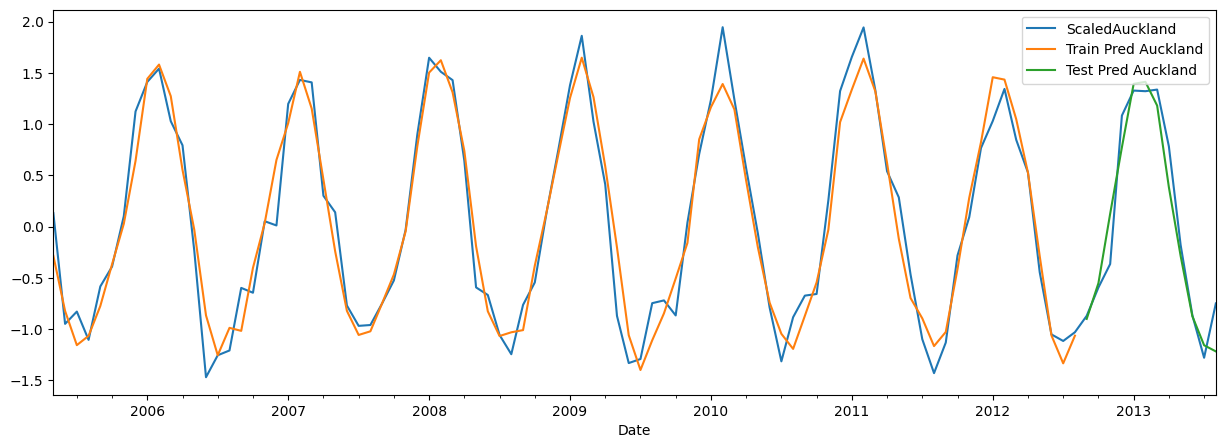

In [204]:
plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

In [205]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = \
  res.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = \
  fcast.predicted_mean['ScaledStockholm']

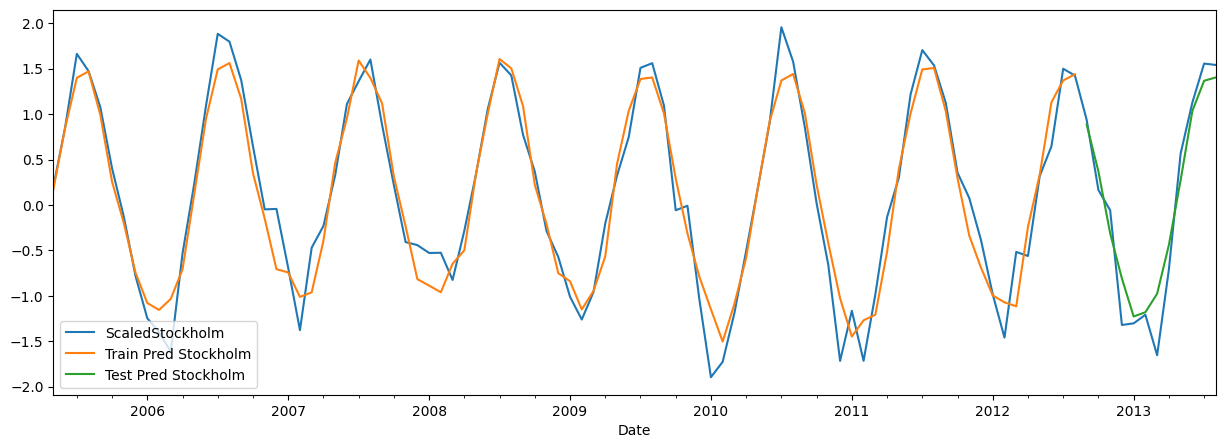

In [206]:
plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

In [207]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
print("Auckland Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print("Auckland Test R^2:", r2_score(y_true, y_pred))

Auckland Train R^2: 0.9295649900096992
Auckland Test R^2: 0.9305070891888304


In [208]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
print("Stockholm Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']
print("Stockholm Test R^2:", r2_score(y_true, y_pred))

Stockholm Train R^2: 0.9246532645158789
Stockholm Test R^2: 0.9314893094244591


In [42]:
# VAR  Now Vector Auto Regressive only (No Vector Moving Average). In VARMA (Vector Auto Regressive Moving Average),
# model is UNSPECIFIED (solution for VAR(p) and VMA(q) is NOT UNIQUE)

In [211]:
model = VAR(train[cols])

In [212]:
lag_order_results = model.select_order(maxlags=15)
lag_order_results

In [213]:
lag_order_results.selected_orders

{'aic': np.int64(12),
 'bic': np.int64(6),
 'hqic': np.int64(11),
 'fpe': np.int64(12)}

In [214]:
results = model.fit(maxlags=15, ic='aic')

In [215]:
lag_order = results.k_ar # In VAR function we don't pass model order. The function deduces it based on crtierian we pass.
# Here we passed Akaike Information Criterian (AIC) for which the function deduced model order as 12

In [217]:
prior = train.iloc[-lag_order:][cols].to_numpy() # why need this?
fcast = results.forecast(prior, Ntest)

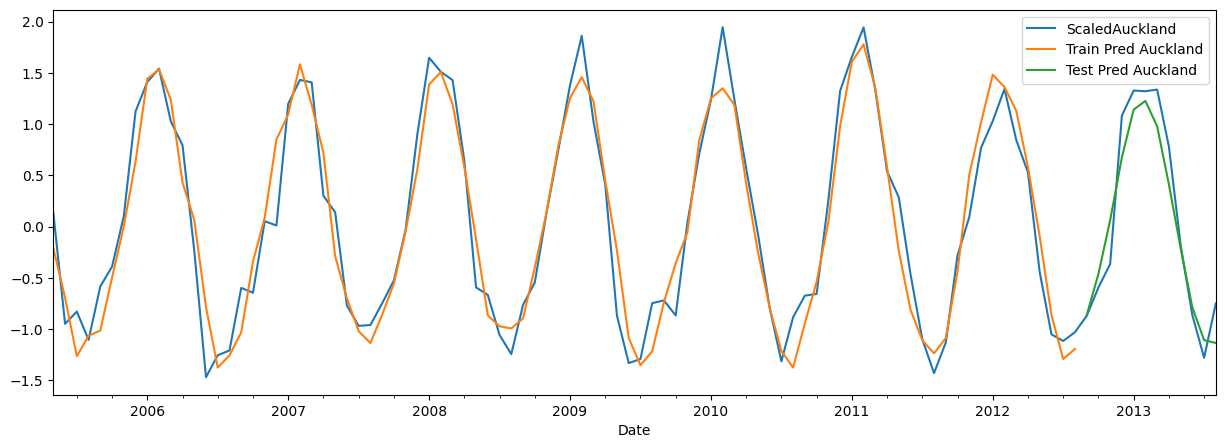

In [218]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = \
  results.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = \
  fcast[:,0]

plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

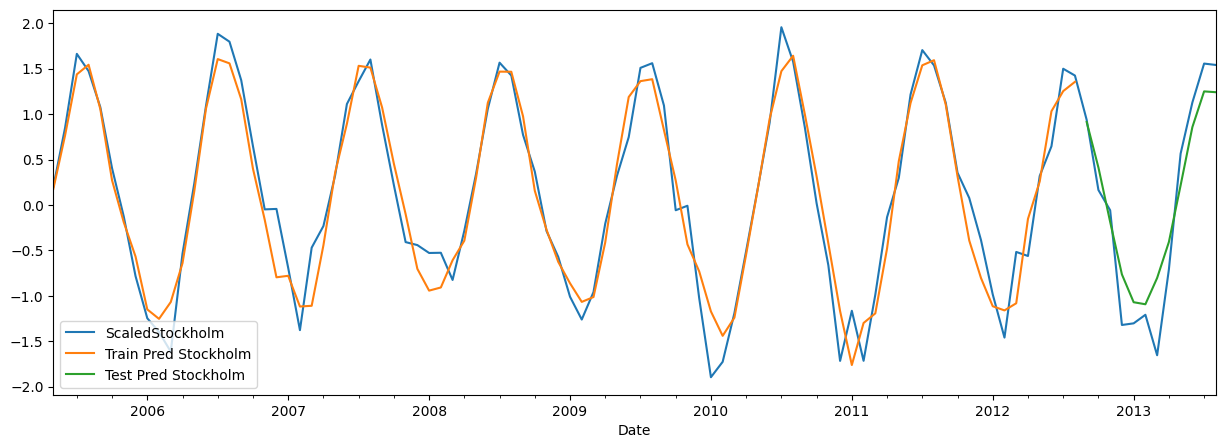

In [219]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = \
  results.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = \
  fcast[:,1]

plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

In [224]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("Auckland Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print("Auckland Test R^2:", r2_score(y_true, y_pred))

Auckland Train R^2: 0.921070700106029
Auckland Test R^2: 0.9233643831340895


In [225]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("Stockholm Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']
print("Stockholm Test R^2:", r2_score(y_true, y_pred))

Stockholm Train R^2: 0.9267030553588321
Stockholm Test R^2: 0.8930437688204875


In [227]:
# ARIMA Baseline: Now we treat each column as INDEPENDENT of EACH OTHER (i.e. no effect of one time series on the other)

In [228]:
from statsmodels.tsa.arima.model import ARIMA

In [230]:
for col in cols:
  model = ARIMA(train[col], order=(10, 0, 10))
  res = model.fit()
  fcast = res.get_forecast(Ntest)
  print(f"{col} Train R^2:", r2_score(joined_part.loc[train_idx, col], res.fittedvalues))
  print(f"{col} Test R^2:", r2_score(joined_part.loc[test_idx, col], fcast.predicted_mean))

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledAuckland Train R^2: 0.9213757839396735
ScaledAuckland Test R^2: 0.9380621414112921
ScaledStockholm Train R^2: 0.9207370859479654
ScaledStockholm Test R^2: 0.9481901552616435


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [231]:
# Exercise: Use Seasonal ARIMA for a more parsimonious model
# Experiments don't result in meaningful better training R square on including seasonal ARMA
for col in cols:
  model = ARIMA(train[col], order=(10, 0, 10), seasonal_order=(10, 0, 3, 12))
  res = model.fit()
  fcast = res.get_forecast(Ntest)
  print(f"{col} Train R^2:", r2_score(joined_part.loc[train_idx, col], res.fittedvalues))
  print(f"{col} Test R^2:", r2_score(joined_part.loc[test_idx, col], fcast.predicted_mean))

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledAuckland Train R^2: 0.923033097271629
ScaledAuckland Test R^2: 0.9353100061620536


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledStockholm Train R^2: 0.9241273629543358
ScaledStockholm Test R^2: 0.9374636861261446
